In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_predict,cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score,f1_score,accuracy_score,precision_recall_curve,recall_score,roc_curve
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [88]:
data = pd.read_csv('./telecom_churn.csv')
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null object
voice mail plan           3333 non-null object
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64

In [5]:
data.isnull().sum().sum()

0

In [6]:
data['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

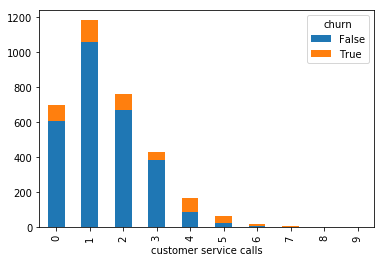

In [11]:
data.groupby(['customer service calls','churn']).size().unstack().plot(kind='bar',stacked=True)

In [15]:
customer_service_rel = data.groupby(['customer service calls','churn']).size().unstack().fillna(0)
customer_service_rel

churn,False,True
customer service calls,,
0,605.0,92.0
1,1059.0,122.0
2,672.0,87.0
3,385.0,44.0
4,90.0,76.0
5,26.0,40.0
6,8.0,14.0
7,4.0,5.0
8,1.0,1.0


In [18]:
customer_service_rel['percentage_churned'] = customer_service_rel[True]/customer_service_rel.sum(axis=1)*100
customer_service_rel

churn,False,True,percentage_churned
customer service calls,,,
0,605.0,92.0,13.196927
1,1059.0,122.0,10.329325
2,672.0,87.0,11.460720
3,385.0,44.0,10.253959
4,90.0,76.0,45.657209
5,26.0,40.0,60.054595
6,8.0,14.0,61.847390
7,4.0,5.0,52.325581
8,1.0,1.0,40.000000


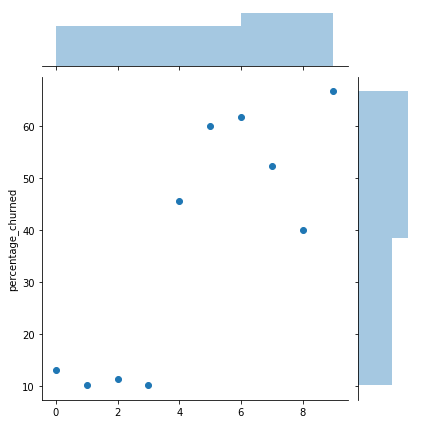

In [24]:
sns.jointplot(customer_service_rel.index,customer_service_rel['percentage_churned'])

In [26]:
data.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


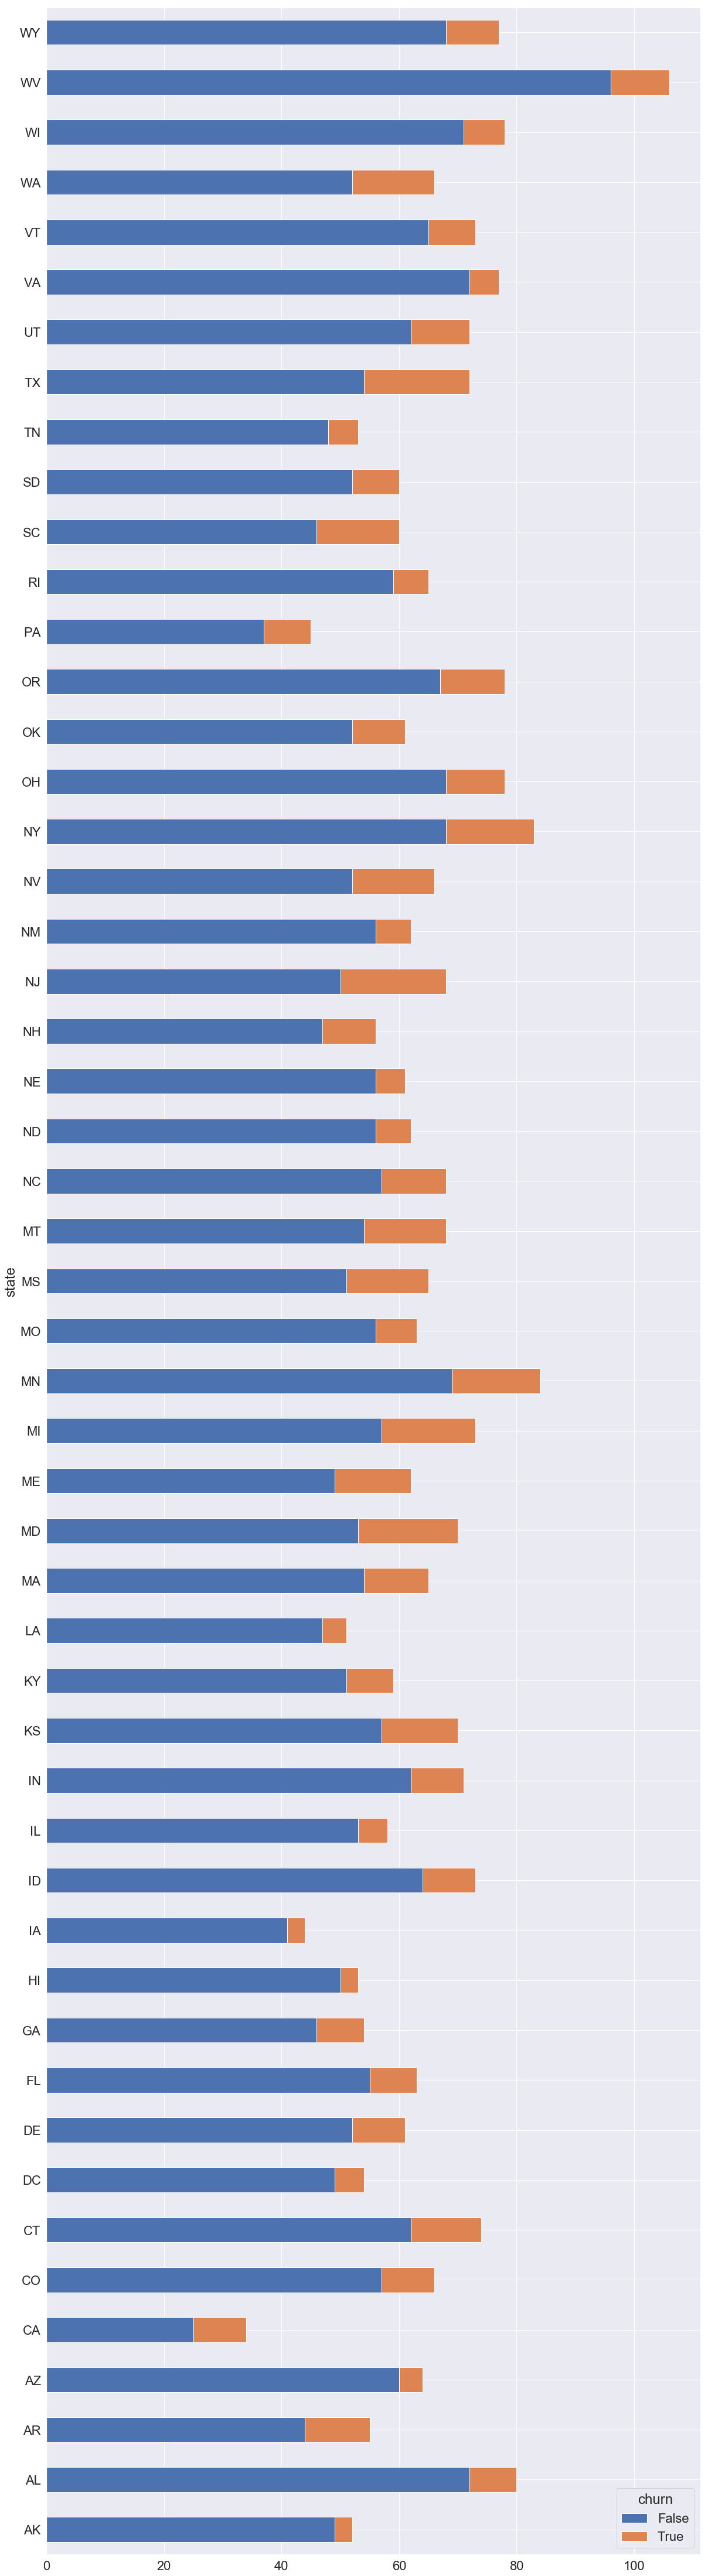

In [35]:
sns.set(font_scale = 2)
data.groupby(['state','churn']).size().unstack().plot(kind='barh',stacked=True ,figsize=(20,80))

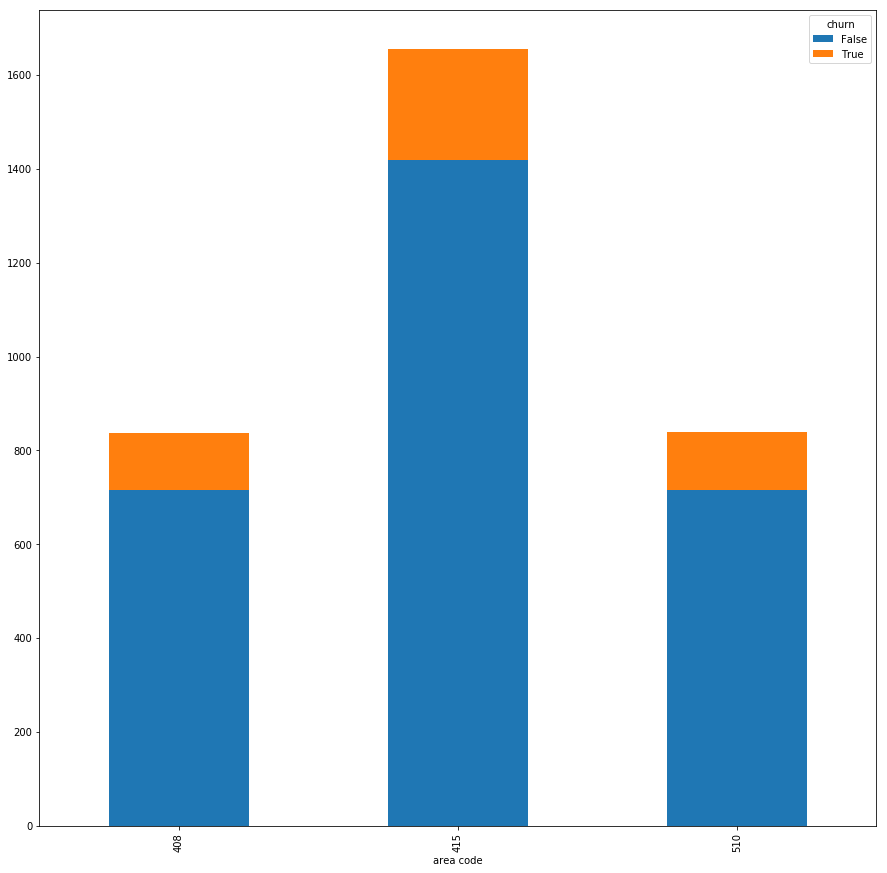

In [32]:
data.groupby(["area code", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(15,15)) 


In [33]:
area_code_rel = data.groupby(["area code", "churn"]).size().unstack()
area_code_rel['percentage_churned'] = area_code_rel[True]/area_code_rel.sum(axis=1)*100
area_code_rel

churn,False,True,percentage_churned
area code,,,
408,716,122,14.558473
415,1419,236,14.259819
510,715,125,14.880952


In [89]:
data_categorical = data.select_dtypes(include=object).drop(labels='phone number',axis=1)
data_categorical = pd.get_dummies(data_categorical)
data_categorical.head()

,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null object
voice mail plan           3333 non-null object
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64

In [91]:
data = pd.concat([data.drop(labels=['state','phone number','international plan','voice mail plan'],axis=1),data_categorical],axis=1)

In [92]:
data.head()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,...,0,0,0,0,0,0,1,0,0,1
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,...,0,0,0,0,0,0,1,0,0,1
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,...,0,0,0,0,0,0,1,0,1,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,...,0,0,0,0,0,0,0,1,1,0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,...,0,0,0,0,0,0,0,1,1,0


In [97]:
Y = data['churn']
X = data.drop(labels='churn',axis=1)

In [98]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 71 columns):
account length            3333 non-null int64
area code                 3333 non-null int64
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64
customer service calls    3333 non-null int64
state_AK                  3333 non-null uint8
state_AL                  3333 non-null uint8
state_AR                  3333 non-null uint8
sta

In [101]:
X_train,X_test,Y_train,Y_test = train_test_split(X.as_matrix(),list(Y),test_size=0.2)

In [102]:
vot_clf = VotingClassifier([('log',LogisticRegression()),('dec_clf',DecisionTreeClassifier())],voting='soft',n_jobs=-1)

xgb_clf = xgb.XGBClassifier(max_depth=6,n_estimators=500,learning_rate=0.1,reg_alpha=0.3)

gb_clf = GradientBoostingClassifier(n_estimators=300,max_depth=6,min_impurity_decrease=0.2)

rf_clf = RandomForestClassifier(n_estimators=300,max_depth=6,min_impurity_decrease=0.2,max_features=0.5)

log_clf  = LogisticRegression()

In [103]:
clfs = [vot_clf,xgb_clf,gb_clf,rf_clf,log_clf]

In [104]:
for clf in clfs:
    print(clf.__class__.__name__," has f1-> ",cross_val_score(clf,X,Y,cv=4,scoring='f1'))
    print(clf.__class__.__name__," has acc-> ",cross_val_score(clf,X,Y,cv=4,scoring='accuracy'))

VotingClassifier  has f1->  [0.692607   0.69709544 0.7372549  0.73770492]
VotingClassifier  has acc->  [0.91007194 0.91486811 0.90876351 0.92067308]
XGBClassifier  has f1->  [0.84848485 0.80733945 0.85454545 0.83105023]
XGBClassifier  has acc->  [0.95803357 0.94964029 0.96158463 0.95552885]
GradientBoostingClassifier  has f1->  [0.8202765  0.79816514 0.83636364 0.80555556]
GradientBoostingClassifier  has acc->  [0.95203837 0.94724221 0.95558223 0.94831731]
RandomForestClassifier  has f1->  [0. 0. 0. 0.]
RandomForestClassifier  has acc->  [0.85491607 0.85491607 0.8547419  0.85576923]
LogisticRegression  has f1->  [0.28742515 0.28735632 0.26415094 0.3253012 ]
LogisticRegression  has acc->  [0.85731415 0.85131894 0.85954382 0.86538462]


In [106]:
gb_clf.fit(X_train,Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.2, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

[0.00190993 0.00084936 0.01877542 0.15055399 0.00996178 0.1473909
 0.0728936  0.00223174 0.06658647 0.02352649 0.00281932 0.01133574
 0.02975791 0.07704197 0.07995249 0.1364006  0.00050371 0.
 0.         0.         0.         0.         0.00065537 0.
 0.         0.00090018 0.         0.00021237 0.00034441 0.0011881
 0.00561989 0.00137344 0.         0.00062649 0.         0.
 0.         0.00015573 0.         0.         0.         0.00034108
 0.         0.         0.         0.         0.0001752  0.00077823
 0.0002279  0.00106094 0.         0.         0.         0.00023157
 0.00051434 0.         0.         0.         0.         0.00091847
 0.         0.         0.         0.00028167 0.         0.
 0.00016911 0.04656513 0.04558565 0.03214107 0.02744224]


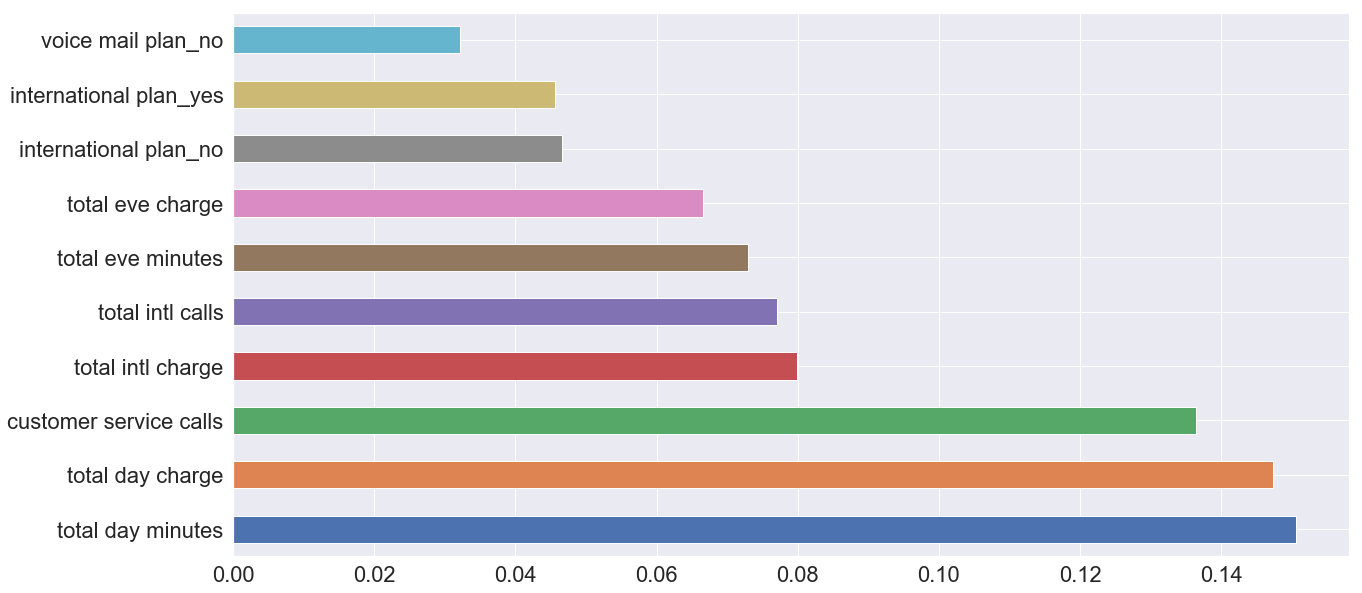

In [109]:
feature_importance = gb_clf.feature_importances_
print (gb_clf.feature_importances_)
feat_importances = pd.Series(gb_clf.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(10)
feat_importances.plot(kind='barh' , figsize=(20,10)) 

In [117]:
Y_pred = gb_clf.predict_proba(X_test)
Y_pred_pos = Y_pred[:,1]

In [119]:
precision,recall,threshold = precision_recall_curve(Y_test,Y_pred_pos)

In [123]:
threshold.shape

(166,)

Text(0.5, 0, 'Threshold')

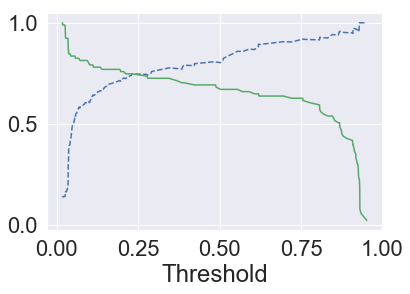

In [125]:
plt.plot(threshold, precision[:-1], "b--", label="Precision")
plt.plot(threshold, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")

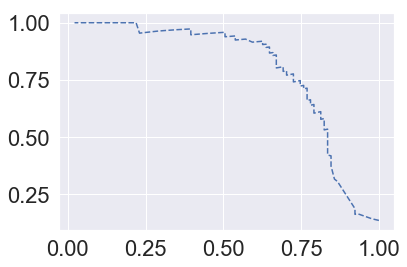

In [126]:
plt.plot(recall[:-1], precision[:-1], "b--", label="Precision")

In [143]:
fpr,tpr,thresholds = roc_curve(Y_test,Y_pred_pos)

Text(0, 0.5, 'True Positive Rate')

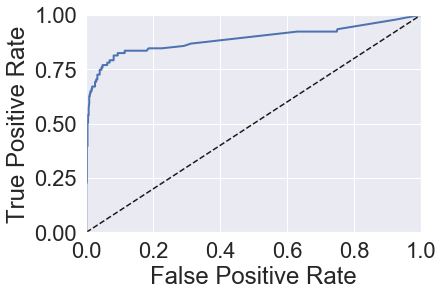

In [145]:
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [147]:
roc_auc_score(Y_test, Y_pred_pos)

0.888526404151404